In [7]:
from monai.transforms import (
    LoadImage,
    LoadImaged,
    EnsureChannelFirstd,
    ToMetaTensord,
    Orientationd,
    NormalizeIntensityd,
    ToNumpy,
    MapTransform,
    Compose,
)

import numpy as np
import glob
import csv


In [8]:
TRAINING_DATASET_PATH = r"../MICCAI_BraTS2020_TrainingData"
seg_files = list(glob.glob(f"{TRAINING_DATASET_PATH}/*/*_seg.nii.gz"))

Finding the Max and Average Boundary (x,y,z) that each segmentation class WT, TC, ET have in the database to try and find a middle ground patch size

In [9]:
load_and_transform= Compose(
    LoadImage(image_only=True),
)

In [10]:
l = load_and_transform(seg_files[0])

Procedure:
- Load Image
- Convert to Numpy
- Numpy `where` to find x,y,z index for WT, TC and ET
- Calculate Min Max from each axis for  WT, TC and ET
- Take Max and Log the data in a csv for processing later

In [63]:

for file in seg_files:
    try:
        loaded_image = load_and_transform(file)
        loaded_image = np.array(loaded_image)

        WT = np.where(
            np.logical_or(
                np.logical_or(loaded_image == 1, loaded_image == 2), loaded_image == 4
            )
        )


        WT_X = np.max(WT[0]) - np.min(WT[0]) if len(WT[0]) > 0 else np.nan
        WT_Y = np.max(WT[1]) - np.min(WT[1]) if len(WT[1]) > 0 else np.nan
        WT_Z = np.max(WT[2]) - np.min(WT[2]) if len(WT[2]) > 0 else np.nan


        TC = np.where(np.logical_or(loaded_image==4,loaded_image==1))

        TC_X = np.max(TC[0]) - np.min(TC[0]) if len(TC[0]) > 0 else np.nan
        TC_Y = np.max(TC[1]) - np.min(TC[1]) if len(TC[1]) > 0 else np.nan
        TC_Z = np.max(TC[2]) - np.min(TC[2]) if len(TC[2]) > 0 else np.nan


        ET = np.where(loaded_image==4)

        ET_X = np.max(ET[0]) - np.min(ET[0]) if len(ET[0]) > 0 else np.nan
        ET_Y = np.max(ET[1]) - np.min(ET[1]) if len(ET[1]) > 0 else np.nan
        ET_Z = np.max(ET[2]) - np.min(ET[2]) if len(ET[2]) > 0 else np.nan


        with open("./seg_boundary.csv",'a') as f:
            w = csv.writer(f,delimiter=',',lineterminator='\n')

            w.writerow([
                WT_X,
                WT_Y,
                WT_Z,
                TC_X,
                TC_Y,
                TC_Z,
                ET_X,
                ET_Y,
                ET_Z,
            ])
    except Exception as e:
        print(f"Error in {file}")
        print(e)


In [64]:
import pandas as pd

In [65]:
data = pd.read_csv("./Boundary_Experiments/seg_boundary.csv",delimiter=',',
names=["WT_X","WT_Y","WT_Z","TC_X","TC_Y","TC_Z","ET_X","ET_Y","ET_Z"])

In [68]:
data.describe()

,WT_X,WT_Y,WT_Z,TC_X,TC_Y,TC_Z,ET_X,ET_Y,ET_Z
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,342.000000,342.000000,342.000000
mean,62.035230,83.243902,65.785908,42.948509,53.574526,45.094851,40.064327,49.298246,42.093567
std,17.293859,21.788013,15.068871,15.323861,20.105848,14.816604,15.000155,19.622357,15.038465
min,24.000000,26.000000,22.000000,11.000000,13.000000,10.000000,5.000000,6.000000,5.000000
25%,51.000000,69.000000,55.000000,32.000000,37.000000,36.000000,29.000000,34.250000,32.000000
50%,60.000000,83.000000,67.000000,42.000000,53.000000,45.000000,40.000000,49.000000,42.500000
75%,72.000000,97.000000,77.000000,52.000000,66.000000,55.000000,50.000000,62.750000,52.000000
max,125.000000,161.000000,103.000000,107.000000,126.000000,98.000000,107.000000,126.000000,94.000000


In [11]:
import torch
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Activations,
    AsDiscrete,
)
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.data import Dataset, DataLoader, decollate_batch

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    strides=(2, 2, 2),
    channels=[15, 30, 60, 120],
    num_res_units=0,
).to(device)

chk = torch.load("./Patch_Size_Experiment_Results/EP50_NovoGrad_Warming/Best_Metric_PatchSize_(120, 120, 120).pth")


model.load_state_dict(chk["model"])



<All keys matched successfully>

In [15]:
torch.onnx.export(model,torch.ones([1,4,120,120,120]),"patch_120_2_res.onnx")

In [4]:
import glob
Validation_Cases = list(glob.glob("../MICCAI_BraTS2020_TrainingData/*"))

In [13]:
experiment_cases = []

for case in Validation_Cases:
    t1 = list(glob.glob(f"{case}/*t1.nii.gz"))
    t1ce = list(glob.glob(f"{case}/*t1ce.nii.gz"))
    t2 = list(glob.glob(f"{case}/*t2.nii.gz"))
    flair = list(glob.glob(f"{case}/*flair.nii.gz"))
    seg = glob.glob(f"{case}/*seg.nii.gz")[0]

    img = t1 + t1ce + t2 + flair

    d = {"image": img, "seg": seg}
    experiment_cases.append(d)

    break


In [14]:
class ConvertLabelsIntoOneHotd(MapTransform):
    """Takes input tensor of segmentation which contains
    values in set (0,1,2,4) where\n
    0 -> Background/Normal\n
    1 -> Non- Enhancing Tumor Core\n
    2 -> Edema\n
    4 -> Enhancing tumor core\n

    and returns a one hot encoded 3 channel tensor where
    1st Channel -> Whole tumor (1,2 and 4)
    2nd Channel -> Tumor Core (1 and 4)
    3rd Channel -> Enhancing Tumor core (4)
    """
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                torch.logical_or(
                    torch.logical_or(data_dict[key] == 1, data_dict[key] == 2),
                    data_dict[key] == 4,
                ), # Whole Tumor
                torch.logical_or(data_dict[key] == 1, data_dict[key] == 4), # Tumor Core
                data_dict[key] == 4, # Enhancing Core
            ]
            data_dict[key] = torch.stack(one_hot_encode_array, axis=0).astype(torch.float32)
        return data_dict



transform_validation_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        ToMetaTensord(keys=["image", "seg"]),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [15]:
dataset = Dataset(experiment_cases, transform_validation_dataset)
val_data_loader = DataLoader(dataset, shuffle=False, batch_size=1)


In [25]:
def inference(input):
        """Do Sliding Window Inference on input tensor
        To avoid OOM Error, Input Model done on CPU.
        Patch taken from input and its inference done on GPU
        to speed up inference time.

        Args:
            input: Full input to pass in the model. For the case
            of this project size => (3,240,240,155)
        """

        def _compute(input):
            return sliding_window_inference(
                inputs=input.to("cpu"),
                roi_size=(120,120,120),
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
                padding_mode="constant",
                sw_device="cuda:0",
                device="cpu",
            )

        with torch.cuda.amp.autocast():
            return _compute(input)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_processing_validation = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


In [11]:
model.eval()
with torch.no_grad():
    for val_data in val_data_loader:
        val_inputs, val_labels = (
            val_data["image"],
            val_data["seg"].to(device),
        )

        val_outputs = inference(val_inputs)

        val_outputs_post = [
            post_processing_validation(i)
            for i in decollate_batch(val_outputs.to(device))
        ]
        dice_metric(y_pred=val_outputs_post, y=val_labels)
        dice_metric_batch(y_pred=val_outputs_post, y=val_labels)

    metric = dice_metric.aggregate().item()

    metric_batch = dice_metric_batch.aggregate()
    metric_wt = metric_batch[0].item()
    metric_tc = metric_batch[1].item()
    metric_et = metric_batch[2].item()


In [12]:
val_inputs.shape

torch.Size([1, 4, 240, 240, 155])

In [13]:
type(val_outputs)

monai.data.meta_tensor.MetaTensor

In [14]:
val_outputs.shape

torch.Size([1, 3, 240, 240, 155])

In [15]:
decollated_output = decollate_batch(val_outputs.to(device))

In [16]:
type(decollated_output)

list

In [17]:
len(decollated_output)

1

In [18]:
decollated_output[0].shape

torch.Size([3, 240, 240, 155])

In [19]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee','notebook'])

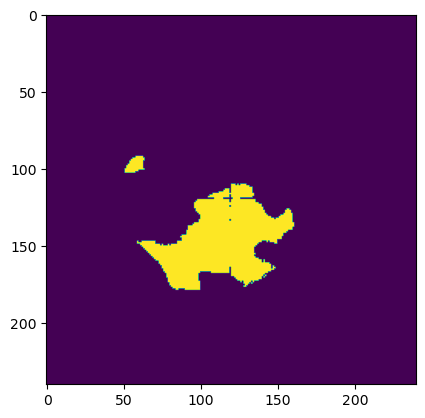

In [26]:
plt.imshow(val_outputs_post[0].cpu()[0,:,:,75])

In [20]:
def inference(input):
        """Do Sliding Window Inference on input tensor
        To avoid OOM Error, Input Model done on CPU.
        Patch taken from input and its inference done on GPU
        to speed up inference time.

        Args:
            input: Full input to pass in the model. For the case
            of this project size => (3,240,240,155)
        """

        def _compute(input):
            return sliding_window_inference(
                inputs=input.to("cpu"),
                roi_size=(120,120,120),
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
                padding_mode="constant",
                sw_device="cuda:0",
                device="cpu",
            )

        with torch.cuda.amp.autocast():
            return _compute(input)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_processing_validation = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)



def evaluate_model(model, case, TRAINING_DATASET_PATH = r"../MICCAI_BraTS2020_TrainingData"):
    t1 = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case}/*t1.nii.gz"))
    t1ce = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case}/*t1ce.nii.gz"))
    t2 = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case}/*t2.nii.gz"))
    flair = list(glob.glob(f"{TRAINING_DATASET_PATH}/*{case}/*flair.nii.gz"))
    seg = glob.glob(f"{TRAINING_DATASET_PATH}/*{case}/*seg.nii.gz")

    img = t1 + t1ce + t2 + flair

    d = {"image": img, "seg": seg}

    val_data = Dataset([d], transform_validation_dataset)
    val_data_loader = DataLoader(val_data,batch_size=1,shuffle=False)

    model.eval()
    with torch.no_grad():
        for val_data in val_data_loader:
            val_inputs, val_labels = (
                val_data["image"],
                val_data["seg"].to(device),
            )

            val_outputs = inference(val_inputs)

            val_outputs_post = [
                post_processing_validation(i)
                for i in decollate_batch(val_outputs.to(device))
            ]
            dice_metric(y_pred=val_outputs_post, y=val_labels)
            dice_metric_batch(y_pred=val_outputs_post, y=val_labels)


        metric = dice_metric.aggregate().item()

        metric_batch = dice_metric_batch.aggregate()
        metric_wt = metric_batch[0].item()
        metric_tc = metric_batch[1].item()
        metric_et = metric_batch[2].item()

        dice_metric.reset()

        dice_metric_batch.reset()

        return {
            "input" : val_data,
            "output": val_outputs_post,
            "metrics": {
                "average": metric,
                "wt" : metric_wt,
                "tc" : metric_tc,
                "et" : metric_et
            }
        }
   

In [33]:
result = evaluate_model(model,310)

Text(0.5, 1.0, 'Y: ET')

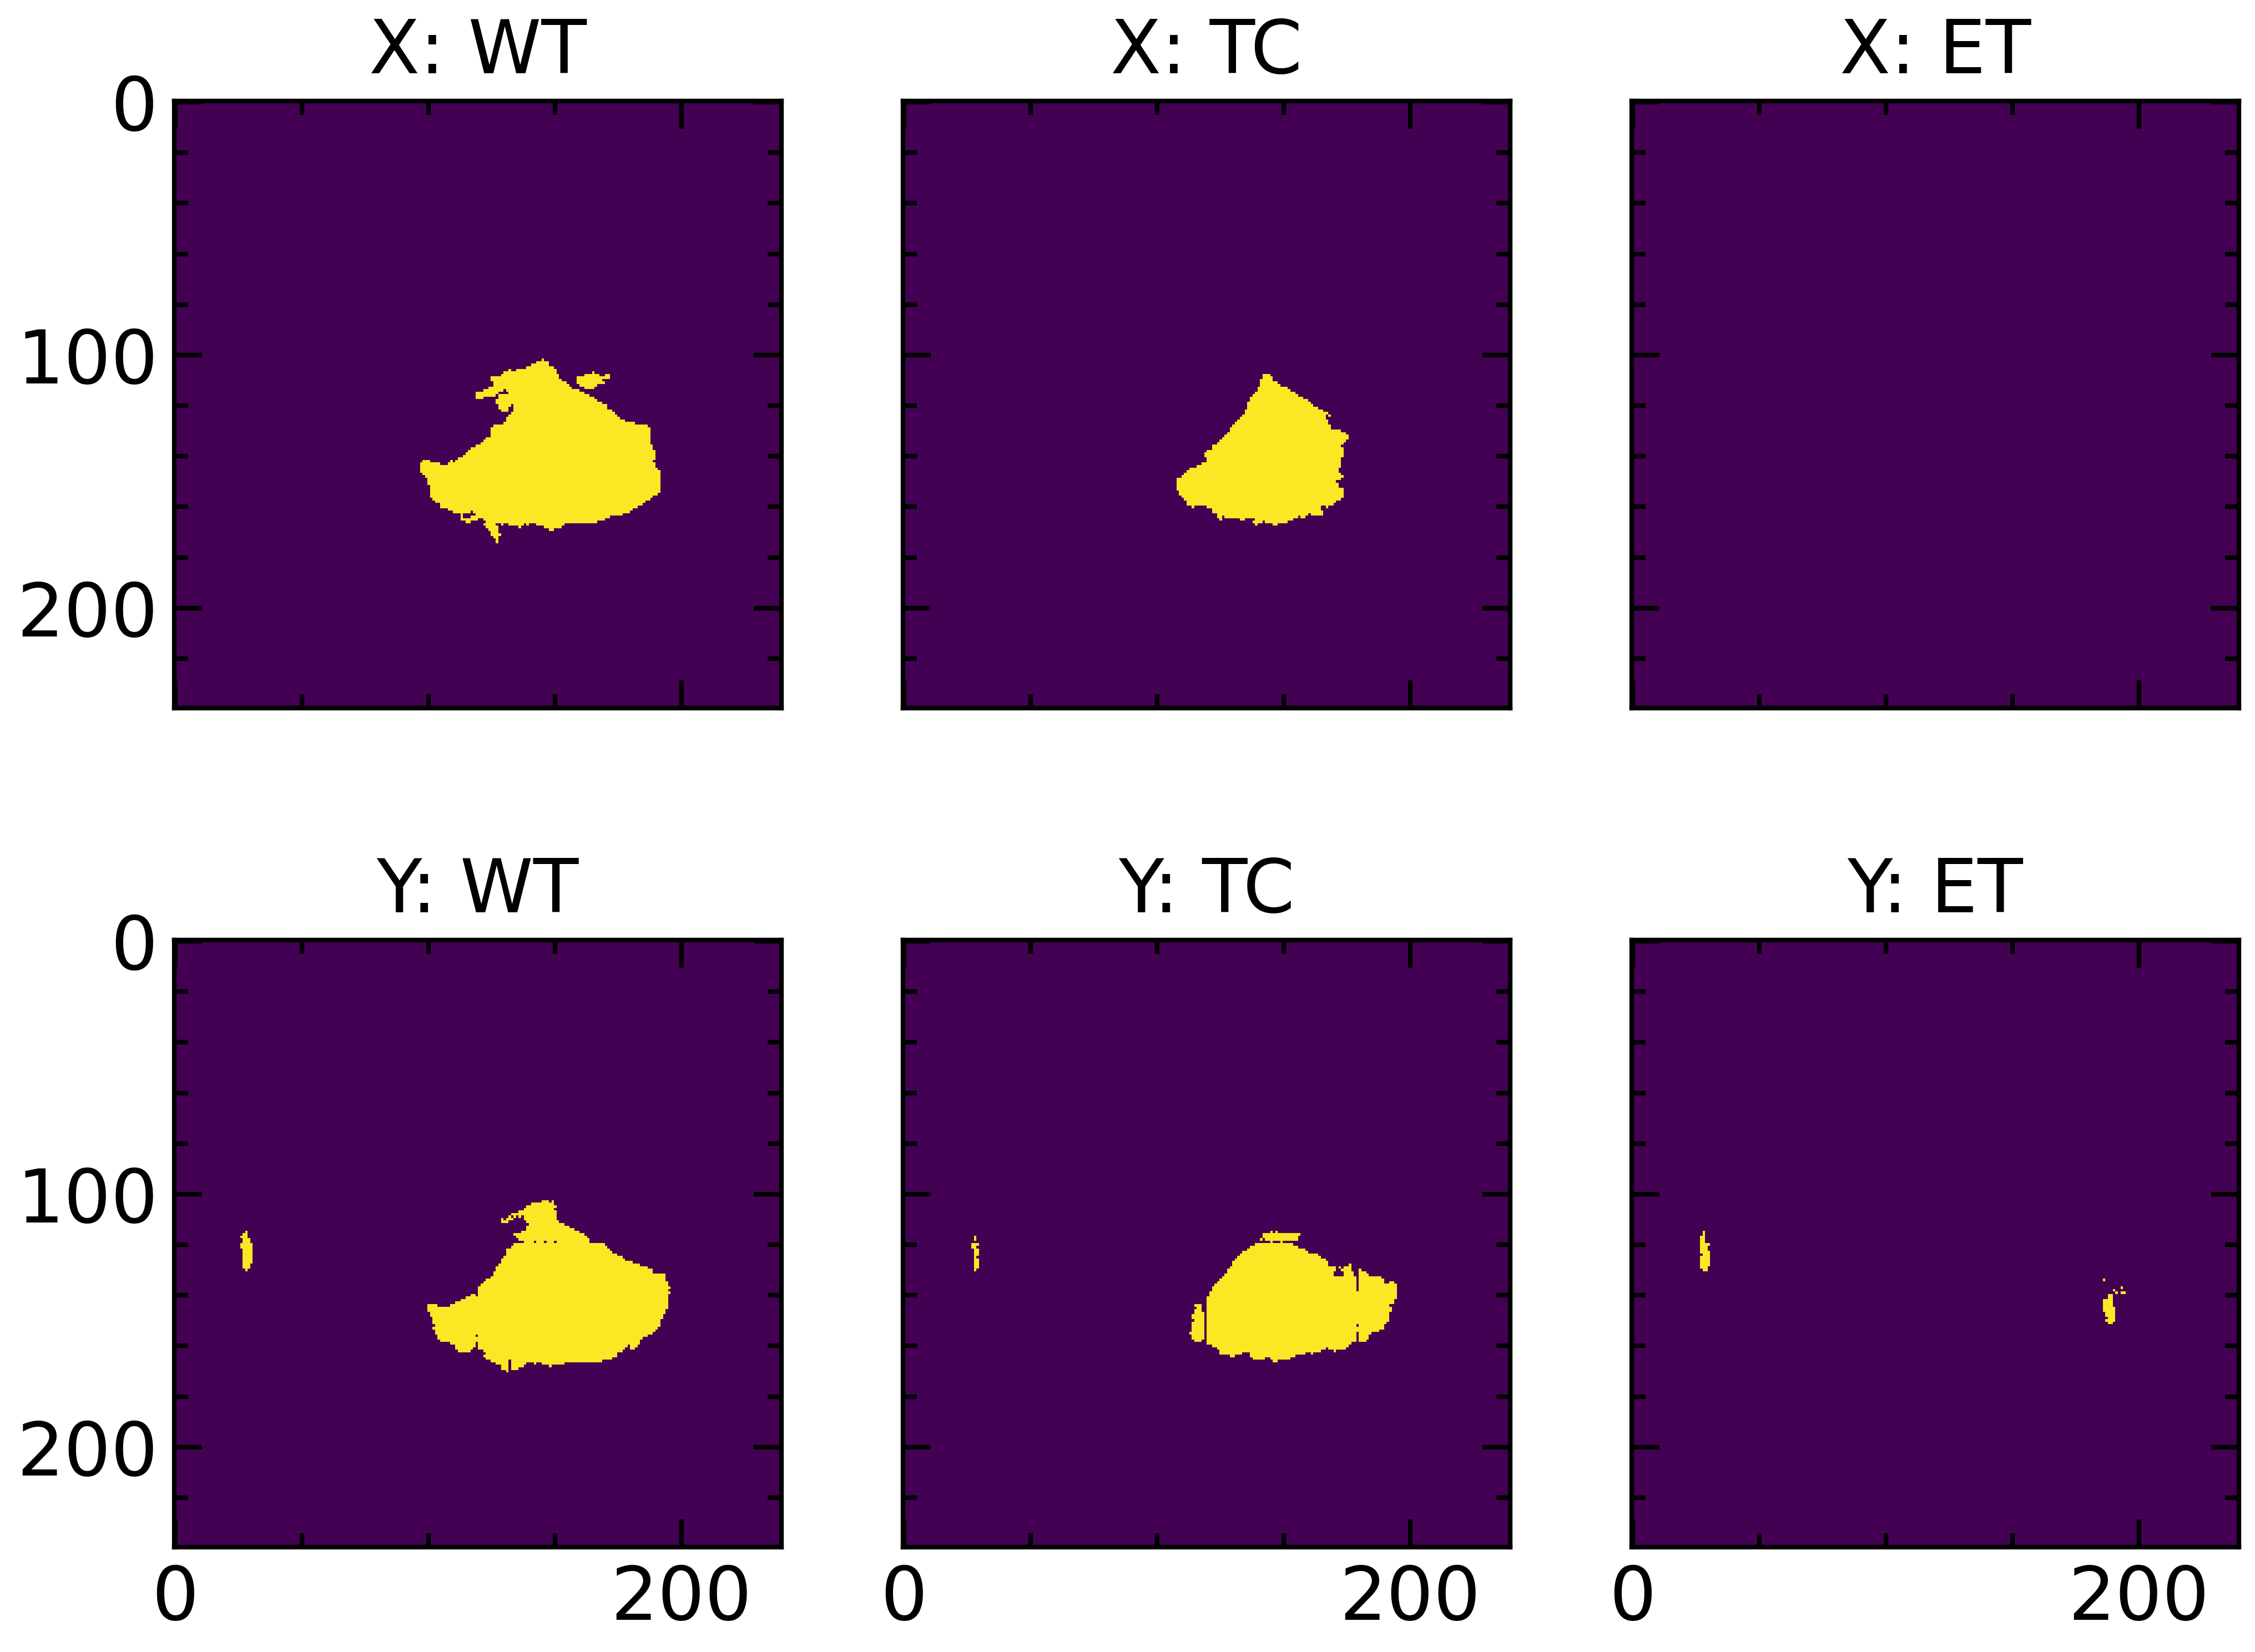

In [35]:

input_seq = result['input']['seg'][0,...]
output_seq = result['output'][0]

fig, ax = plt.subplots(2,3,sharex=True, sharey=True)

slice_to_plot = 75

# Input Sequence

ax[0,0].imshow(input_seq[0,:,:,slice_to_plot].cpu())
ax[0,0].set_title("X: WT")

ax[0,1].imshow(input_seq[1,:,:,slice_to_plot].cpu())
ax[0,1].set_title("X: TC")

ax[0,2].imshow(input_seq[2,:,:,slice_to_plot].cpu())
ax[0,2].set_title("X: ET")


ax[1,0].imshow(output_seq[0,:,:,slice_to_plot].cpu())
ax[1,0].set_title("Y: WT")

ax[1,1].imshow(output_seq[1,:,:,slice_to_plot].cpu())
ax[1,1].set_title("Y: TC")

ax[1,2].imshow(output_seq[2,:,:,slice_to_plot].cpu())
ax[1,2].set_title("Y: ET")


